In [1]:
from configparser import ConfigParser
import glob, os, cv2
from pandas import StringDtype
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from pickletools import optimize
import string
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.regularizers import L2
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
import tensorflow.keras.backend as K
import tensorflow as tf
import matplotlib.pyplot as plt
import time
# from draw_ellipse import *
# from ellipses import *
# from bwperim import *
os.environ["CUDA_VISIBLE_DEVICES"]='2,3'
mirrored_strategy = tf.distribute.MirroredStrategy()

# BASE_PATH = "C:/kwoncy/eye/temp_xml/pair/data_sets/eye2"
BASE_PATH_NONBLINK = "./new_data_sets/eye_nonblink"
BASE_PATH_BLINK = "./new_data_sets/eye_blink"
img_height = 240
img_width = 320
FX = 2
FY = 2
SEED = 555

time_start = time.time()

blink_lt_original_paths = sorted(glob.glob(BASE_PATH_BLINK + '/Lt.original/*.png'))
n_blink_lt_imgs = len(blink_lt_original_paths)
print("number of blink_lt_imgs : ", n_blink_lt_imgs)
imgs_lt_original_blink = np.stack([ cv2.imread(f'{BASE_PATH_BLINK}/Lt.original/{i}.png',0) for i in range(n_blink_lt_imgs)])
imgs_lt_original_blink = imgs_lt_original_blink.astype('float32') / 255.

masks_lt_pupil_blink = np.stack([ cv2.imread(f'{BASE_PATH_BLINK}/Lt.pupil/{i}.png',0) for i in range(n_blink_lt_imgs)])
masks_lt_pupil_blink = masks_lt_pupil_blink.astype('float32') / 255.

imgs_train1, imgs_val1, masks_train1, masks_val1 = train_test_split(imgs_lt_original_blink,masks_lt_pupil_blink,test_size=0.2, shuffle=True, random_state=SEED)
print("train_val 1 shape :", imgs_train1.shape, imgs_val1.shape, masks_train1.shape, masks_val1.shape)


blink_rt_original_paths = sorted(glob.glob(BASE_PATH_BLINK + '/Rt.original/*.png'))
n_blink_rt_imgs = len(blink_rt_original_paths)
print("number of blink_rt_imgs : ", n_blink_rt_imgs)
imgs_rt_original_blink = np.stack([ cv2.imread(f'{BASE_PATH_BLINK}/Rt.original/{i}.png',0) for i in range(n_blink_rt_imgs)])
imgs_rt_original_blink = imgs_rt_original_blink.astype('float32') / 255.

masks_rt_pupil_blink = np.stack([ cv2.imread(f'{BASE_PATH_BLINK}/Rt.pupil/{i}.png',0) for i in range(n_blink_rt_imgs)])
masks_rt_pupil_blink = masks_rt_pupil_blink.astype('float32') / 255.

imgs_train2, imgs_val2, masks_train2, masks_val2 = train_test_split(imgs_rt_original_blink,masks_rt_pupil_blink,test_size=0.2, shuffle=True, random_state=SEED)
print("train_val 2 shape :", imgs_train2.shape, imgs_val2.shape, masks_train2.shape, masks_val2.shape)


non_blink_lt_original_paths = sorted(glob.glob(BASE_PATH_NONBLINK + '/Lt.original/*.png'))
n_non_blink_lt_imgs = len(non_blink_lt_original_paths)

l_rand_lt_index = np.random.RandomState(seed = SEED).choice(n_non_blink_lt_imgs, n_blink_lt_imgs, replace=False)
print("number of non_blink_lt_imgs : ", len(l_rand_lt_index))

imgs_lt_original_non_blink = np.stack([ cv2.imread(f'{BASE_PATH_NONBLINK}/Lt.original/{i}.png',0) for i in l_rand_lt_index])
imgs_lt_original_non_blink = imgs_lt_original_non_blink.astype('float32') / 255.

masks_lt_pupil_non_blink = np.stack([ cv2.imread(f'{BASE_PATH_NONBLINK}/Lt.pupil/{i}.png',0) for i in l_rand_lt_index])
masks_lt_pupil_non_blink = masks_lt_pupil_non_blink.astype('float32') / 255.

imgs_train3, imgs_val3, masks_train3, masks_val3 = train_test_split(imgs_lt_original_non_blink,masks_lt_pupil_non_blink,test_size=0.2, shuffle=True, random_state=SEED)
print("train_val 3 shape :", imgs_train3.shape, imgs_val3.shape, masks_train3.shape, masks_val3.shape)


non_blink_rt_original_paths = sorted(glob.glob(BASE_PATH_NONBLINK + '/Rt.original/*.png'))
n_non_blink_rt_imgs = len(non_blink_rt_original_paths)

l_rand_rt_index = np.random.RandomState(seed = SEED).choice(n_non_blink_rt_imgs, n_blink_rt_imgs, replace=False)
print("number of non_blink_rt_imgs : ", len(l_rand_rt_index))

imgs_rt_original_non_blink = np.stack([ cv2.imread(f'{BASE_PATH_NONBLINK}/Rt.original/{i}.png',0) for i in l_rand_rt_index])
imgs_rt_original_non_blink = imgs_rt_original_non_blink.astype('float32') / 255.

masks_rt_pupil_non_blink = np.stack([ cv2.imread(f'{BASE_PATH_NONBLINK}/Rt.pupil/{i}.png',0) for i in l_rand_rt_index])
masks_rt_pupil_non_blink = masks_rt_pupil_non_blink.astype('float32') / 255.


imgs_train4, imgs_val4, masks_train4, masks_val4 = train_test_split(imgs_rt_original_non_blink,masks_rt_pupil_non_blink,test_size=0.2, shuffle=True, random_state=SEED)
print("train_val 4 shaep :", imgs_train4.shape, imgs_val4.shape, masks_train4.shape, masks_val4.shape)


imgs_train_whole = np.concatenate([imgs_train1, imgs_train2, imgs_train3, imgs_train4], axis=0)
imgs_val_whole = np.concatenate([imgs_val1, imgs_val2, imgs_val3, imgs_val4], axis=0)
masks_train_whole = np.concatenate([masks_train1, masks_train2, masks_train3, masks_train4], axis=0)
masks_val_whole = np.concatenate([masks_val1, masks_val2, masks_val3, masks_val4], axis=0)

# imgs_train_whole = np.concatenate([imgs_train3, imgs_train4], axis=0)
# imgs_val_whole = np.concatenate([imgs_val3, imgs_val4], axis=0)
# masks_train_whole = np.concatenate([masks_train3, masks_train4], axis=0)
# masks_val_whole = np.concatenate([masks_val3, masks_val4], axis=0)



print("total of train_val :", imgs_train_whole.shape, imgs_val_whole.shape, masks_train_whole.shape, masks_val_whole.shape)
time_end = time.time()
print("loading times :", time_end - time_start)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
number of blink_lt_imgs :  1181
train_val 1 shape : (944, 240, 320) (237, 240, 320) (944, 240, 320) (237, 240, 320)
number of blink_rt_imgs :  1223
train_val 2 shape : (978, 240, 320) (245, 240, 320) (978, 240, 320) (245, 240, 320)
number of non_blink_lt_imgs :  1181
train_val 3 shape : (944, 240, 320) (237, 240, 320) (944, 240, 320) (237, 240, 320)
number of non_blink_rt_imgs :  1223
train_val 4 shaep : (978, 240, 320) (245, 240, 320) (978, 240, 320) (245, 240, 320)
total of train_val : (3844, 240, 320) (964, 240, 320) (3844, 240, 320) (964, 240, 320)
loading times : 150.3246569633484


In [2]:
time_start = time.time()

imgs_train_flip1 = imgs_train_whole[:,:,-1::-1].copy()
imgs_val_flip1 = imgs_val_whole[:,:,-1::-1].copy()
masks_train_flip1 = masks_train_whole[:,:,-1::-1].copy()
masks_val_flip1 = masks_val_whole[:,:,-1::-1].copy()

imgs_train_concat1 = np.concatenate([imgs_train_whole, imgs_train_flip1], axis=0)
imgs_val_concat1 = np.concatenate([imgs_val_whole, imgs_val_flip1], axis=0)
masks_train_concat1 = np.concatenate([masks_train_whole, masks_train_flip1], axis=0)
masks_val_concat1 = np.concatenate([masks_val_whole, masks_val_flip1], axis=0)

print("train_val_flip1 : ", imgs_train_concat1.shape, imgs_val_concat1.shape, masks_train_concat1.shape, masks_val_concat1.shape)

# imgs_train_flip2 = imgs_train_concat1[:,-1::-1,:].copy()
# imgs_val_flip2 = imgs_val_concat1[:,-1::-1,:].copy()
# masks_train_flip2 = masks_train_concat1[:,-1::-1,:].copy()
# masks_val_flip2 = masks_val_concat1[:,-1::-1,:].copy()

# imgs_train_concat2 = np.concatenate([imgs_train_concat1, imgs_train_flip2], axis=0)
# imgs_val_concat2 = np.concatenate([imgs_val_concat1, imgs_val_flip2], axis=0)
# masks_train_concat2 = np.concatenate([masks_train_concat1, masks_train_flip2], axis=0)
# masks_val_concat2 = np.concatenate([masks_val_concat1, masks_val_flip2], axis=0)

# print("train_val_flip2 : ", imgs_train_concat2.shape, imgs_val_concat2.shape, masks_train_concat2.shape, masks_val_concat2.shape)

imgs_train = imgs_train_concat1
imgs_val = imgs_val_concat1
masks_train = masks_train_concat1
masks_val = masks_val_concat1

time_end = time.time()
print("loading times :", time_end - time_start)

train_val_flip1 :  (7688, 240, 320) (1928, 240, 320) (7688, 240, 320) (1928, 240, 320)
loading times : 2.294610023498535


In [3]:
class DCGAN():
    def __init__(self):
        self.img_height = 240
        self.img_width = 320
        self.img_channels = 1
        self.img_shape = (self.img_height, self.img_width, self.img_channels)
        self.latent_dim = 100
        
        OPTIMIZER = Adam(0.0002, 0.5)
        
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', optimizer=OPTIMIZER, metrics=['acc'])
        
        self.generator = self.build_generator()
        
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)
        
        self.discriminator.trainable = False
        
        valid = self.discriminator(img)
        
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=OPTIMIZER)
        
        
    def build_generator(self):
        ACTIVATION = 'elu'
        KERNEL_INIT = 'he_uniform'
        FILTERS = 64
        
        input_layer = Input(shape=self.latent_dim)
        layer1 = Dense(30 * 40 * FILTERS * 4, activation=ACTIVATION)(input_layer)
        layer2 = Reshape((30,40,FILTERS *4 ))(layer1)
        layer3 = UpSampling2D()(layer2)
        
        layer4 = Conv2D(FILTERS *4, kernel_size=(3,3), activation=None, padding='same', kernel_initializer=KERNEL_INIT)(layer3)
        layer5 = BatchNormalization()(layer4)
        layer6 = Activation(ACTIVATION)(layer5)
        layer7 = UpSampling2D()(layer6)
        
        layer8 = Conv2D(FILTERS *2, kernel_size=(3,3), activation=None, padding='same', kernel_initializer=KERNEL_INIT)(layer7)
        layer9 = BatchNormalization()(layer8)
        layer10 = Activation(ACTIVATION)(layer9)
        layer11 = UpSampling2D()(layer10)
        
        layer12 = Conv2D(FILTERS, kernel_size=(3,3), activation=None, padding='same', kernel_initializer=KERNEL_INIT)(layer11)
        layer13 = BatchNormalization()(layer12)
        layer14 = Activation(ACTIVATION)(layer13)
        
        output_layer = Conv2D(self.img_channels, kernel_size=(1,1), activation='tanh')(layer14)
        
        return Model(input_layer, output_layer)
        
        
    def build_discriminator(self):
        ACTIVATION = 'elu'
        KERNEL_INIT = 'he_uniform'
        FILTERS = 64
        IMG_HEIGHT = 240
        IMG_WIDTH = 320
        IMG_CHANNELS = 1
        
        input_layer = Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
        layer1 = Conv2D(FILTERS, kernel_size=(3,3), activation=None, padding='same', kernel_initializer=KERNEL_INIT)(input_layer)
        layer2 = BatchNormalization()(layer1)
        layer3 = Activation(ACTIVATION)(layer2)
        layer4 = MaxPool2D(strides=(2,2))(layer3)
        
        layer5 = Conv2D(FILTERS *2, kernel_size=(3,3), activation=None, padding='same', kernel_initializer=KERNEL_INIT)(layer4)
        layer6 = BatchNormalization()(layer5)
        layer7 = Activation(ACTIVATION)(layer6)
        layer8 = MaxPool2D(strides=(2,2))(layer7)
        
        layer9 = Conv2D(FILTERS *4, kernel_size=(3,3), activation=None, padding='same', kernel_initializer=KERNEL_INIT)(layer8)
        layer10 = BatchNormalization()(layer9)
        layer11 = Activation(ACTIVATION)(layer10)
        layer12 = MaxPool2D(strides=(2,2))(layer11)
        
        layer13 = Conv2D(FILTERS *8, kernel_size=(3,3), activation=None, padding='same', kernel_initializer=KERNEL_INIT)(layer12)
        layer14 = BatchNormalization()(layer13)
        layer15 = Activation(ACTIVATION)(layer14)
        
        layer16 = Flatten()(layer15)
        output_layer = Dense(1, activation='sigmoid')(layer16)
        
        return Model(input_layer, output_layer)
    
    def train(self, epochs=20, trains=None, vals=None, batch_size=10, save_interval=50):
        
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        
        train_set = trains
        
        for epoch in range(epochs):
            start_time = time.time()
            for i in range(len(trains)//batch_size):
                idx = np.random.choice(len(train_set), batch_size, replace=False)
                not_idx = np.array([True] * len(train_set))
                not_idx[idx] = False
                
                imgs = train_set[idx]
                train_set = train_set[not_idx]
                
                noise = np.random.normal(0,1,(batch_size, self.latent_dim))
                gen_imgs = self.generator.predict(noise)
                
                d_loss_real = self.discriminator.train_on_batch(imgs, valid)
                d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
                
                g_loss = self.combined.train_on_batch(noise, valid)
                
            train_set = trains
            print(f'{epoch} D loss: {d_loss[0]}, D acc : {d_loss[1]}, G loss : {g_loss}')
            print("time :", time.time() - start_time)    
        
        print("train done")
        
        
        

In [4]:
EPOCHS = 5
BATCH_SIZE = 5
NUM_IMAGES = 4

imgs_train_axis_add = imgs_train[:,:,:,np.newaxis]

dcgan = DCGAN()
dcgan.train(epochs=EPOCHS, trains=imgs_train_axis_add, batch_size = BATCH_SIZE)



0 D loss: 0.0, D acc : 1.0, G loss : 1.8153135263263332e-25
time : 649.9543662071228
1 D loss: 0.0, D acc : 1.0, G loss : 3.632122190707464e-30
time : 643.9540798664093
2 D loss: 0.0, D acc : 1.0, G loss : 2.1009360200526112e-17
time : 645.704026222229
3 D loss: 0.0, D acc : 1.0, G loss : 7.931931720185521e-33
time : 645.5075516700745
4 D loss: 0.0, D acc : 1.0, G loss : 8.195464917075606e-32
time : 643.7762939929962


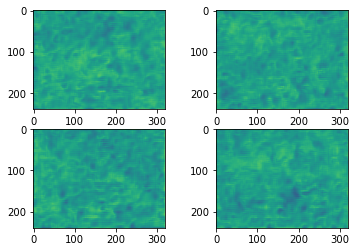

In [8]:
noise = np.random.normal(0,1,(NUM_IMAGES,100))

gen_imgs = dcgan.generator.predict(noise)

for i in range(NUM_IMAGES):
    plt.subplot(NUM_IMAGES//2, NUM_IMAGES//2, i+1)
    plt.imshow(gen_imgs[i])
                         
plt.show()
        


In [9]:
dcgan.train(epochs=EPOCHS, trains=imgs_train_axis_add, batch_size = BATCH_SIZE)

0 D loss: 0.0, D acc : 1.0, G loss : 4.231325293447806e-21
time : 644.7301335334778
1 D loss: 0.0, D acc : 1.0, G loss : 8.29290604392572e-28
time : 643.7579061985016
2 D loss: 0.0, D acc : 1.0, G loss : 6.393066522031821e-30
time : 643.82319688797
3 D loss: 0.0, D acc : 1.0, G loss : 1.480108960761313e-35
time : 644.8236927986145
4 D loss: 0.0, D acc : 1.0, G loss : 7.609481016104538e-29
time : 645.0932273864746


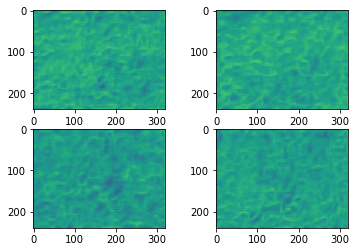

In [10]:
noise = np.random.normal(0,1,(NUM_IMAGES,100))

gen_imgs = dcgan.generator.predict(noise)

for i in range(NUM_IMAGES):
    plt.subplot(NUM_IMAGES//2, NUM_IMAGES//2, i+1)
    plt.imshow(gen_imgs[i])
                         
plt.show()

In [11]:
img_ = gen_imgs[0]

img_ = img_.squeeze()
img_ = (img_ * 255).astype(np.uint8)

cv2.imshow('img',img_)
